In [1]:
%load_ext autoreload
%autoreload 2

import jax  # noqa: I001
jax.config.update("jax_enable_x64", True)

import numpyro  # noqa: E402, I001
numpyro.set_host_device_count(4)

import numpy as np  # noqa: E402, I001

## Fit the Data

In [2]:
import pprint

from des_y6_imsim_analysis import interpolant
from des_y6_imsim_analysis.stats import compute_model_chi2_info, measure_map, run_mcmc
from des_y6_imsim_analysis.utils import (
    measure_m_dz,
    plot_results_delta_nz,
    plot_results_fg_model,
    plot_results_nz,
    read_data_one_tomo_bin,
)


def _measure_m_dz(fname, kwargs):
    print("======================================================")
    print(fname)
    print("======================================================")
    model_module = interpolant

    data = read_data_one_tomo_bin(fname)

    model_data = model_module.make_model_data(
        z=data.z,
        nzs=data.nzs,
        mn=data.mn,
        cov=data.cov,
        mn_pars=data.mn_pars,
        zbins=data.zbins,
        **kwargs,
    )

    map_params = measure_map(
        model_module=model_module,
        model_data=model_data,
        seed=254,
        progress_bar=True,
        num_steps=50_000,
        learning_rate=1e-2,
    )

    chi2_info = compute_model_chi2_info(
        model_module=model_module,
        model_data=model_data,
        data=data,
        params=map_params,
    )

    print("chi2:", chi2_info['chi2'])
    print("dof:", chi2_info['dof'])
    print("p-value:", chi2_info['p_value'])
    print("m vals:\n    model: %r\n    data: %r\n     err: %r" % (
        (chi2_info['model_mn'][:data.nzs.shape[0]] - 1).tolist(),
        (data.mn[:data.nzs.shape[0]] - 1).tolist(),
        (np.sqrt(np.diag(data.cov)[:data.nzs.shape[0]])).tolist(),
    ))
    print("map params:\n", pprint.pformat(map_params))

    mcmc = run_mcmc(
        model_module=model_module,
        model_data=model_data,
        init_params=map_params,
        seed=231,
        progress_bar=True,
        dense_mass=True,
        num_samples=2000,
    )

    mcmc.print_summary(exclude_deterministic=False)
    samples = mcmc.get_samples()

    # plot_results_nz(model_module=model_module, model_data=model_data, samples=samples)
    # plot_results_delta_nz(model_module=model_module, model_data=model_data, samples=samples)
    # plot_results_fg_model(model_module=model_module, model_data=model_data, samples=samples)

    mdz = measure_m_dz(
        model_module=model_module,
        model_data=model_data,
        samples=samples,
        return_dict=True,
        shift_negative=True,
    )

    m_mn = [np.mean(mdz[f"m_b{i}"]) for i in range(4)]
    m_sd = [np.std(mdz[f"m_b{i}"]) for i in range(4)]

    dz_mn = [np.mean(mdz[f"dz_b{i}"]) for i in range(4)]
    dz_sd = [np.std(mdz[f"dz_b{i}"]) for i in range(4)]

    print("|--------------------------------------------|")
    print("| bin | m [10^-3, 3sigma] | dz               |")
    print("|--------------------------------------------|")
    for i in range(data.nzs.shape[0]):
        print(
            "| %d   | %+5.1f +/- %-5.1f   | %+0.3f +/- %0.3f |" % (
                i, m_mn[i]/1e-3, m_sd[i]/1e-3 * 3, dz_mn[i], dz_sd[i]
            )
        )
    print("|--------------------------------------------|")
    print("======================================================")
    print("======================================================\n\n")

    return [dz_mn[0], dz_sd[0], m_mn[0], m_sd[0]]


In [5]:
fnames = [
    "../../data/N_gamma_alpha_v3_statistical_i_20.0_20.5.hdf5",
    "../../data/N_gamma_alpha_v3_statistical_i_20.5_21.0.hdf5",
    "../../data/N_gamma_alpha_v3_statistical_i_21.0_21.5.hdf5",
    "../../data/N_gamma_alpha_v3_statistical_i_21.5_22.0.hdf5",
    "../../data/N_gamma_alpha_v3_statistical_i_22.0_22.5.hdf5",
    "../../data/N_gamma_alpha_v3_statistical_i_22.5_23.0.hdf5",
    "../../data/N_gamma_alpha_v3_statistical_i_23.0_23.5.hdf5",
    "../../data/N_gamma_alpha_v3_statistical_i_23.5_24.0.hdf5",
    "../../data/N_gamma_alpha_v3_statistical_i_24.0_24.5.hdf5",
]

kwargs = {
    "num_pts": 10,
    "model_kind": "f",
}
# kwargs = {
#     "num_pts": 9,
#     "model_kind": "F",
#     "fixed_param_values": {
#         "g_b0": 0.0, "g_b1": 0.0, "g_b2": 0.0, "g_b3": 0.0,
#     },
# }

mags = np.array([20.25, 20.75, 21.25, 21.75, 22.25, 22.75, 23.25, 23.75, 24.25])
dz_mn_sd = []

for fname in fnames:
    dz_mn_sd.append(_measure_m_dz(fname, kwargs))

dz_mn_sd = np.array(dz_mn_sd)

../../data/N_gamma_alpha_v3_statistical_i_20.0_20.5.hdf5


100%|██████████| 50000/50000 [00:10<00:00, 4737.09it/s, init loss: 397516.5138, avg. loss [47501-50000]: -62.5582]


chi2: 2.1708803273337147
dof: 1
p-value: 0.14064570073634974
m vals:
    model: [0.0016516082292117318]
    data: [0.0012652377073005816]
     err: [0.005869356159836015]
map params:
 {'a0_b0': Array(0.07322024, dtype=float64),
 'a1_b0': Array(0.11088854, dtype=float64),
 'a2_b0': Array(0.086306, dtype=float64),
 'a3_b0': Array(0.03123787, dtype=float64),
 'a4_b0': Array(0.0368319, dtype=float64),
 'a5_b0': Array(7.08838409e-11, dtype=float64),
 'a6_b0': Array(0.01231857, dtype=float64),
 'a7_b0': Array(6.94113889e-11, dtype=float64),
 'a8_b0': Array(0.08027237, dtype=float64),
 'a9_b0': Array(0.05103425, dtype=float64)}


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     a0_b0      0.07      0.00      0.07      0.07      0.07   7623.45      1.00
     a1_b0      0.11      0.00      0.11      0.11      0.11   7100.98      1.00
     a2_b0      0.08      0.01      0.08      0.06      0.10   5036.45      1.00
     a3_b0      0.06      0.04      0.05      0.00      0.11   6754.18      1.00
     a4_b0      0.07      0.05      0.06      0.00      0.13   7181.85      1.00
     a5_b0      0.06      0.05      0.05      0.00      0.13   8641.60      1.00
     a6_b0      0.08      0.06      0.07      0.00      0.18   7377.56      1.00
     a7_b0      0.09      0.07      0.07      0.00      0.20   9030.60      1.00
     a8_b0      0.17      0.12      0.15      0.00      0.33   7512.58      1.00
     a9_b0      0.08      0.05      0.08      0.00      0.14   5250.80      1.00

Number of divergences: 0
|--------------------------------------------|
| bin | m [10^-3, 3sigma] | dz     

100%|██████████| 50000/50000 [00:10<00:00, 4684.26it/s, init loss: 472210.4850, avg. loss [47501-50000]: -61.8084]


chi2: 3.1642752800356733
dof: 1
p-value: 0.075265834298875
m vals:
    model: [-0.0028875289663676806]
    data: [-0.0036973363958674454]
     err: [0.005558815752370876]
map params:
 {'a0_b0': Array(0.09041376, dtype=float64),
 'a1_b0': Array(0.0915758, dtype=float64),
 'a2_b0': Array(0.09151013, dtype=float64),
 'a3_b0': Array(1.65418982e-11, dtype=float64),
 'a4_b0': Array(0.0643699, dtype=float64),
 'a5_b0': Array(0.04745765, dtype=float64),
 'a6_b0': Array(0.0780048, dtype=float64),
 'a7_b0': Array(0.17791659, dtype=float64),
 'a8_b0': Array(1.52289295e-10, dtype=float64),
 'a9_b0': Array(0.09451679, dtype=float64)}


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     a0_b0      0.09      0.00      0.09      0.09      0.09   8257.14      1.00
     a1_b0      0.09      0.00      0.09      0.09      0.09   8094.84      1.00
     a2_b0      0.09      0.00      0.09      0.09      0.10   6878.98      1.00
     a3_b0      0.02      0.02      0.02      0.00      0.05   9108.57      1.00
     a4_b0      0.08      0.05      0.07      0.00      0.15   6488.64      1.00
     a5_b0      0.10      0.07      0.08      0.00      0.19   8336.46      1.00
     a6_b0      0.13      0.09      0.12      0.00      0.26   8034.32      1.00
     a7_b0      0.22      0.14      0.20      0.00      0.41   7416.02      1.00
     a8_b0      0.14      0.11      0.12      0.00      0.29   7401.67      1.00
     a9_b0      0.11      0.05      0.11      0.02      0.19   6033.07      1.00

Number of divergences: 0
|--------------------------------------------|
| bin | m [10^-3, 3sigma] | dz     

100%|██████████| 50000/50000 [00:10<00:00, 4696.98it/s, init loss: 654611.3279, avg. loss [47501-50000]: -56.3869]


chi2: 14.18749377697266
dof: 1
p-value: 0.00016546662653287868
m vals:
    model: [-0.0020000517717690958]
    data: [-0.0016698680387916554]
     err: [0.004880230448528096]
map params:
 {'a0_b0': Array(0.07805784, dtype=float64),
 'a1_b0': Array(0.10040851, dtype=float64),
 'a2_b0': Array(0.09331862, dtype=float64),
 'a3_b0': Array(0.05448165, dtype=float64),
 'a4_b0': Array(0.03497633, dtype=float64),
 'a5_b0': Array(0.00422053, dtype=float64),
 'a6_b0': Array(1.42906386e-11, dtype=float64),
 'a7_b0': Array(3.49625541e-11, dtype=float64),
 'a8_b0': Array(0.47027042, dtype=float64),
 'a9_b0': Array(1.35306623e-11, dtype=float64)}


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     a0_b0      0.08      0.00      0.08      0.08      0.08   7328.35      1.00
     a1_b0      0.10      0.00      0.10      0.10      0.10   7858.52      1.00
     a2_b0      0.09      0.00      0.09      0.09      0.10   5258.15      1.00
     a3_b0      0.05      0.02      0.05      0.02      0.09   3567.37      1.00
     a4_b0      0.07      0.05      0.06      0.00      0.15   6605.87      1.00
     a5_b0      0.07      0.05      0.06      0.00      0.15   9058.90      1.00
     a6_b0      0.04      0.04      0.03      0.00      0.09   8251.72      1.00
     a7_b0      0.08      0.07      0.07      0.00      0.18   8316.37      1.00
     a8_b0      0.49      0.22      0.48      0.08      0.82   7074.65      1.00
     a9_b0      0.04      0.03      0.03      0.00      0.08   8239.91      1.00

Number of divergences: 0
|--------------------------------------------|
| bin | m [10^-3, 3sigma] | dz     

100%|██████████| 50000/50000 [00:10<00:00, 4651.83it/s, init loss: 734194.0008, avg. loss [47501-50000]: -60.0069]


chi2: 6.074968090587268
dof: 1
p-value: 0.013711077757758625
m vals:
    model: [0.0024352852361184674]
    data: [0.0011876484025099554]
     err: [0.004888662201296815]
map params:
 {'a0_b0': Array(0.07768255, dtype=float64),
 'a1_b0': Array(0.10137436, dtype=float64),
 'a2_b0': Array(0.09448016, dtype=float64),
 'a3_b0': Array(0.06606435, dtype=float64),
 'a4_b0': Array(0.10747244, dtype=float64),
 'a5_b0': Array(9.18976575e-11, dtype=float64),
 'a6_b0': Array(0.11916225, dtype=float64),
 'a7_b0': Array(2.43616269e-11, dtype=float64),
 'a8_b0': Array(3.98349705e-11, dtype=float64),
 'a9_b0': Array(1.4548175e-11, dtype=float64)}


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     a0_b0      0.08      0.00      0.08      0.08      0.08   8659.06      1.00
     a1_b0      0.10      0.00      0.10      0.10      0.10   7529.94      1.00
     a2_b0      0.09      0.00      0.09      0.09      0.10   8024.11      1.00
     a3_b0      0.07      0.01      0.07      0.06      0.07   7819.55      1.00
     a4_b0      0.11      0.06      0.11      0.01      0.20   6134.01      1.00
     a5_b0      0.08      0.07      0.07      0.00      0.18  10245.16      1.00
     a6_b0      0.15      0.10      0.13      0.00      0.28   8256.96      1.00
     a7_b0      0.08      0.07      0.06      0.00      0.18   9699.41      1.00
     a8_b0      0.13      0.11      0.10      0.00      0.28   7468.22      1.00
     a9_b0      0.04      0.04      0.03      0.00      0.09   7809.18      1.00

Number of divergences: 0
|--------------------------------------------|
| bin | m [10^-3, 3sigma] | dz     

100%|██████████| 50000/50000 [00:10<00:00, 4867.37it/s, init loss: 725241.0789, avg. loss [47501-50000]: -60.8682]


chi2: 1.7008244617077664
dof: 1
p-value: 0.19218019079495285
m vals:
    model: [-0.0018140851449536255]
    data: [-0.00211171970394175]
     err: [0.004912323888777679]
map params:
 {'a0_b0': Array(0.08905319, dtype=float64),
 'a1_b0': Array(0.09405568, dtype=float64),
 'a2_b0': Array(0.09253449, dtype=float64),
 'a3_b0': Array(0.08482838, dtype=float64),
 'a4_b0': Array(0.01700164, dtype=float64),
 'a5_b0': Array(3.63943307e-11, dtype=float64),
 'a6_b0': Array(0.37558758, dtype=float64),
 'a7_b0': Array(0.10605324, dtype=float64),
 'a8_b0': Array(5.13022053e-11, dtype=float64),
 'a9_b0': Array(0.01291447, dtype=float64)}


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     a0_b0      0.09      0.00      0.09      0.09      0.09   7794.63      1.00
     a1_b0      0.09      0.00      0.09      0.09      0.10   7693.38      1.00
     a2_b0      0.09      0.00      0.09      0.09      0.09   7000.80      1.00
     a3_b0      0.08      0.00      0.08      0.08      0.09   7057.09      1.00
     a4_b0      0.03      0.02      0.02      0.00      0.06   5529.28      1.00
     a5_b0      0.06      0.05      0.05      0.00      0.14   9824.45      1.00
     a6_b0      0.35      0.16      0.35      0.10      0.62   6897.80      1.00
     a7_b0      0.23      0.16      0.21      0.00      0.45  10027.71      1.00
     a8_b0      0.13      0.11      0.10      0.00      0.28   9060.87      1.00
     a9_b0      0.11      0.08      0.10      0.00      0.23   7552.23      1.00

Number of divergences: 0
|--------------------------------------------|
| bin | m [10^-3, 3sigma] | dz     

100%|██████████| 50000/50000 [00:10<00:00, 4846.48it/s, init loss: 640410.7767, avg. loss [47501-50000]: -60.2000]


chi2: 0.031995393475315236
dof: 1
p-value: 0.858037767563526
m vals:
    model: [0.01563099232900056]
    data: [0.01574325548099731]
     err: [0.005123939272084106]
map params:
 {'a0_b0': Array(0.08823564, dtype=float64),
 'a1_b0': Array(0.09752888, dtype=float64),
 'a2_b0': Array(0.09496317, dtype=float64),
 'a3_b0': Array(0.08649547, dtype=float64),
 'a4_b0': Array(0.08245855, dtype=float64),
 'a5_b0': Array(0.01296998, dtype=float64),
 'a6_b0': Array(0.11391306, dtype=float64),
 'a7_b0': Array(0.15444192, dtype=float64),
 'a8_b0': Array(0.15784257, dtype=float64),
 'a9_b0': Array(0.12179011, dtype=float64)}


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     a0_b0      0.09      0.00      0.09      0.08      0.09   7073.44      1.00
     a1_b0      0.10      0.00      0.10      0.09      0.10   7106.95      1.00
     a2_b0      0.09      0.00      0.09      0.09      0.10   6845.20      1.00
     a3_b0      0.09      0.00      0.09      0.08      0.09   7230.79      1.00
     a4_b0      0.08      0.01      0.08      0.07      0.09   6556.41      1.00
     a5_b0      0.03      0.02      0.03      0.00      0.06   7505.12      1.00
     a6_b0      0.11      0.04      0.11      0.04      0.18   4906.87      1.00
     a7_b0      0.16      0.07      0.16      0.04      0.26   4561.75      1.00
     a8_b0      0.17      0.09      0.16      0.02      0.30   4498.52      1.00
     a9_b0      0.13      0.07      0.13      0.01      0.23   4295.07      1.00

Number of divergences: 0
|--------------------------------------------|
| bin | m [10^-3, 3sigma] | dz     

100%|██████████| 50000/50000 [00:10<00:00, 4818.05it/s, init loss: 388678.0997, avg. loss [47501-50000]: -55.4980]


chi2: 3.219031342498121
dof: 1
p-value: 0.07278669021549221
m vals:
    model: [-0.00427946757900266]
    data: [-0.0028866096121270557]
     err: [0.006324402750695496]
map params:
 {'a0_b0': Array(0.08634639, dtype=float64),
 'a1_b0': Array(0.10157855, dtype=float64),
 'a2_b0': Array(0.08823683, dtype=float64),
 'a3_b0': Array(0.09648988, dtype=float64),
 'a4_b0': Array(0.08109432, dtype=float64),
 'a5_b0': Array(0.06558627, dtype=float64),
 'a6_b0': Array(0.02597497, dtype=float64),
 'a7_b0': Array(0.04801576, dtype=float64),
 'a8_b0': Array(0.07139284, dtype=float64),
 'a9_b0': Array(0.04979982, dtype=float64)}


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     a0_b0      0.09      0.00      0.09      0.08      0.09   7990.12      1.00
     a1_b0      0.10      0.00      0.10      0.10      0.10   7688.91      1.00
     a2_b0      0.09      0.00      0.09      0.09      0.09   6988.54      1.00
     a3_b0      0.10      0.00      0.10      0.09      0.10   7678.23      1.00
     a4_b0      0.08      0.00      0.08      0.08      0.09   6486.90      1.00
     a5_b0      0.06      0.01      0.06      0.05      0.08   6929.52      1.00
     a6_b0      0.03      0.02      0.03      0.00      0.05   4734.57      1.00
     a7_b0      0.05      0.03      0.05      0.00      0.09   5204.02      1.00
     a8_b0      0.08      0.04      0.07      0.01      0.13   4632.20      1.00
     a9_b0      0.05      0.02      0.05      0.01      0.08   5167.37      1.00

Number of divergences: 0
|--------------------------------------------|
| bin | m [10^-3, 3sigma] | dz     

100%|██████████| 50000/50000 [00:10<00:00, 4858.70it/s, init loss: 160918.3606, avg. loss [47501-50000]: -51.4579]


chi2: 1.1713905026822686
dof: 1
p-value: 0.2791157137818792
m vals:
    model: [0.004564659804777493]
    data: [0.0035297552989796976]
     err: [0.009518229252611372]
map params:
 {'a0_b0': Array(0.08215755, dtype=float64),
 'a1_b0': Array(0.10067102, dtype=float64),
 'a2_b0': Array(0.09664741, dtype=float64),
 'a3_b0': Array(0.10292146, dtype=float64),
 'a4_b0': Array(0.08556708, dtype=float64),
 'a5_b0': Array(0.07271449, dtype=float64),
 'a6_b0': Array(0.06845997, dtype=float64),
 'a7_b0': Array(0.05345612, dtype=float64),
 'a8_b0': Array(0.04810968, dtype=float64),
 'a9_b0': Array(0.06736729, dtype=float64)}


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     a0_b0      0.08      0.00      0.08      0.07      0.09   8725.90      1.00
     a1_b0      0.10      0.00      0.10      0.10      0.11   8969.65      1.00
     a2_b0      0.10      0.00      0.10      0.09      0.10   9271.23      1.00
     a3_b0      0.10      0.00      0.10      0.10      0.11  10938.36      1.00
     a4_b0      0.09      0.00      0.09      0.08      0.09   8492.36      1.00
     a5_b0      0.07      0.01      0.07      0.06      0.08   7661.48      1.00
     a6_b0      0.07      0.01      0.07      0.05      0.09   8300.12      1.00
     a7_b0      0.05      0.02      0.05      0.03      0.08   7091.21      1.00
     a8_b0      0.05      0.02      0.05      0.01      0.08   4818.84      1.00
     a9_b0      0.07      0.01      0.07      0.05      0.09   8202.14      1.00

Number of divergences: 0
|--------------------------------------------|
| bin | m [10^-3, 3sigma] | dz     

100%|██████████| 50000/50000 [00:10<00:00, 4871.35it/s, init loss: 24593.1393, avg. loss [47501-50000]: -40.5046]


chi2: 2.662186132772483
dof: 1
p-value: 0.1027594132215352
m vals:
    model: [0.0003175313425609616]
    data: [-0.001423520082866614]
     err: [0.02328194786250383]
map params:
 {'a0_b0': Array(0.08227901, dtype=float64),
 'a1_b0': Array(0.11276261, dtype=float64),
 'a2_b0': Array(0.09313637, dtype=float64),
 'a3_b0': Array(0.09739475, dtype=float64),
 'a4_b0': Array(0.08905208, dtype=float64),
 'a5_b0': Array(0.09602536, dtype=float64),
 'a6_b0': Array(0.05476487, dtype=float64),
 'a7_b0': Array(0.07242672, dtype=float64),
 'a8_b0': Array(0.09928424, dtype=float64),
 'a9_b0': Array(0.06656462, dtype=float64)}


  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     a0_b0      0.08      0.01      0.08      0.06      0.10  10703.67      1.00
     a1_b0      0.11      0.01      0.11      0.10      0.13   9548.98      1.00
     a2_b0      0.09      0.01      0.09      0.08      0.11  10097.13      1.00
     a3_b0      0.10      0.01      0.10      0.08      0.11  10906.44      1.00
     a4_b0      0.09      0.01      0.09      0.08      0.10   8880.56      1.00
     a5_b0      0.10      0.01      0.10      0.08      0.11   9993.64      1.00
     a6_b0      0.05      0.01      0.05      0.03      0.08   9924.29      1.00
     a7_b0      0.07      0.02      0.07      0.04      0.10   7579.15      1.00
     a8_b0      0.10      0.03      0.10      0.06      0.14   6651.91      1.00
     a9_b0      0.07      0.01      0.07      0.04      0.09   9031.02      1.00

Number of divergences: 0
|--------------------------------------------|
| bin | m [10^-3, 3sigma] | dz     

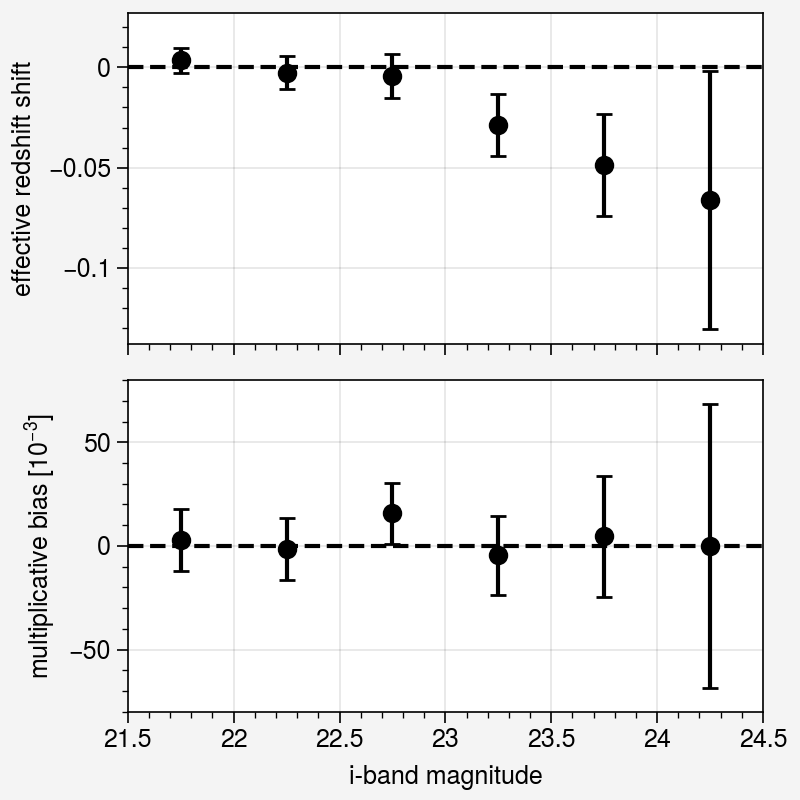

In [6]:
import ultraplot as uplt


fig, axs = uplt.subplots(figsize=(4, 4), nrows=2, ncols=1, sharey=0)

ax = axs[0, 0]
ax.errorbar(
    mags, dz_mn_sd[:, 0], fmt="ko", yerr=dz_mn_sd[:, 1] * 3
)
ax.axhline(0, color="k", linestyle="dashed")
ax.format(
    xlabel="i-band magnitude",
    ylabel="effective redshift shift",
    xlim=(22.5, 24.5),
)

ax = axs[1, 0]
ax.errorbar(
    mags, dz_mn_sd[:, 2] / 1e-3, fmt="ko", yerr=dz_mn_sd[:, 3] / 1e-3 * 3
)
ax.axhline(0, color="k", linestyle="dashed")
ax.format(
    xlabel="i-band magnitude",
    ylabel="multiplicative bias [$10^{-3}$]",
    xlim=(21.5, 24.5),
    ylim=(-80, 80),
)